In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from glob import glob
from natsort import natsorted

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np

from matplotlib.colors import LogNorm

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry
from photutils.background import Background2D

from astropy.stats import mad_std

import cometToolkit as ctk

from astropy.nddata import Cutout2D

# Finding ZeroPoint

In [2]:
dataPaths = natsorted(glob("../../Data/cometData01/" "*.fits"))

vDataPaths = [ path for path in dataPaths if ( int(path.split("_")[-1][:-5]) - 354) % 3 == 0]
rDataPaths = [ path for path in dataPaths if ( int(path.split("_")[-1][:-5]) - 355) % 3 == 0]
bDataPaths = [ path for path in dataPaths if ( int(path.split("_")[-1][:-5]) - 356) % 3 == 0]

In [36]:
vStackedStars = ctk.StackImages(vDataPaths)

(array([441]),)


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
442,1701.0678930913723,1639.3351329069321,0.8308167935580325,-0.09405826069549415,-0.11738955615421355,121,0.0,136740.36500975123,5017.099730353628,-9.251131835144509


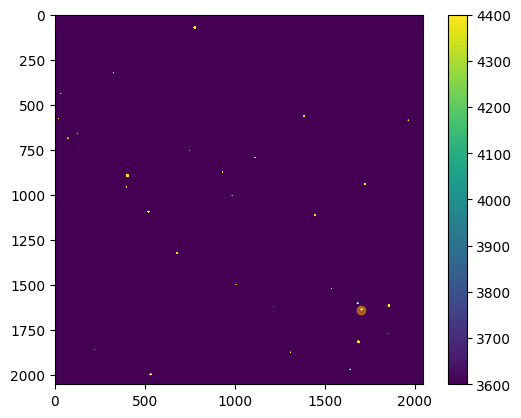

In [71]:
# Use to manually find star locations

sources = ctk.SearchStars(vStackedStars, showPlot=False)

plt.imshow(vStackedStars, vmin=4000, vmax=4000)
plt.colorbar()

# Finding stars
starCentre = (1700, 1650)
tolerance = 20
referenceStarIndices = np.where((abs(sources["xcentroid"] - starCentre[0]) < tolerance) & (abs(sources["ycentroid"] - starCentre[1]) < tolerance))
print(referenceStarIndices)
plt.scatter(sources[referenceStarIndices]["xcentroid"], sources[referenceStarIndices]["ycentroid"], alpha=0.5, color="orange")
sources[referenceStarIndices]

In [59]:
def DetermineStarZeroPoint(image, coordinatesList, calibratedMagnitudes, apertureRadius=30, tolerance=20, showPlot=False):
    
    sources = ctk.SearchStars(image, showPlot=False)

    zeroPoints = []

    # Finding stars
    for i, starCoords in enumerate(coordinatesList):
        starX = starCoords[0]
        starY = starCoords[1]

        referenceStarIndices = np.where((abs(sources["xcentroid"] - starCentre[0]) < tolerance) & (abs(sources["ycentroid"] - starCentre[1]) < tolerance))
        #print(referenceStarIndices)

        if showPlot:        
            plt.scatter(sources[referenceStarIndices]["xcentroid"], sources[referenceStarIndices]["ycentroid"], alpha=0.5, color="orange")

        #print(sources[referenceStarIndices])
        if len(sources[referenceStarIndices]) > 1:
            raise Exception("Too many stars found within tolerance for star: " + str(i))

        
        # Create aperture
        aperture = CircularAperture((sources[referenceStarIndices][0]["xcentroid"], sources[referenceStarIndices][0]["ycentroid"]), r=apertureRadius)

        # Find background
        background = Background2D(image, 50).background

        phot_table = aperture_photometry(vStackedStars - background, aperture)
        
        observedMagnitude = -2.5 * np.log10( phot_table["aperture_sum"] / (120 * len(vDataPaths)))

        
        zeroPoint = calibratedMagnitudes[i] - observedMagnitude
        zeroPoints.append(zeroPoint[0])

    return zeroPoints

In [99]:
coordinates = [(400, 890), (1720, 940), (1680, 1820), (1700, 1650)]
vCalibratedMagnitudes = [11.84, 13.24, 13.15, 12.19]
rCalibratedMagnitudes = [11.84, 13.24, 13.15, 12.19]
bCalibratedMagnitudes = [11.84, 13.24, 13.15, 12.19]


vZeroPoint = np.mean(DetermineStarZeroPoint(vStackedStars, coordinates, vCalibratedMagnitudes, apertureRadius=30))
rZeroPoint = np.mean(DetermineStarZeroPoint(vStackedStars, coordinates, rCalibratedMagnitudes, apertureRadius=30))
bZeroPoint = np.mean(DetermineStarZeroPoint(vStackedStars, coordinates, bCalibratedMagnitudes, apertureRadius=30))

# Aperture Curve

In [78]:
vImageStacked = ctk.GetImage("../DataProducts/vStacked.fits")

 id     xcentroid         ycentroid         sharpness           roundness1           roundness2      npix sky        peak              flux              mag        
--- ----------------- ----------------- ------------------ -------------------- -------------------- ---- --- ----------------- ----------------- ------------------
 15 926.5991618755206 926.4001123960127 0.5776587095594163 -0.12505930074381733 -0.09929226869445132  121 0.0 5712.177080588452 97.24155291595339 -4.969629714420538


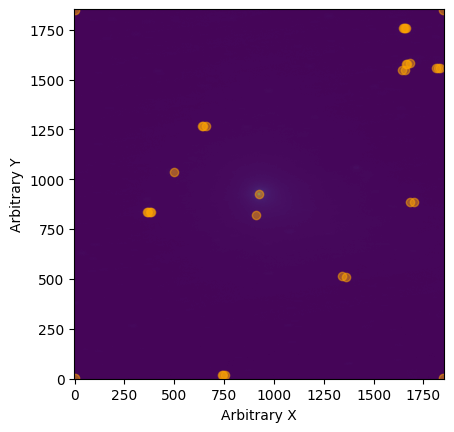

In [79]:
sources = ctk.SearchStars(vImageStacked, showPlot=True)

#for s in sources:
#    print(s)

comet = sources[14]
print(comet)

In [80]:
# Activity
from sbpy.data import Ephem
from sbpy.calib import solar_fluxd
from sbpy.activity import Afrho

import astropy.units as u

# Function to do this for range of apertures

In [96]:
def FindActivityCurve(image, comet, apertureRangeKm, zeroPoint, showPlot=False):
    
    activity = []
    cometDistance = 0.585 * 1.496e8 # au to km

    for aKm in apertureRangeKm:
        # Convert aperture range from km to pixel
        aPixel = (180 * 3600) / (0.6 * np.pi) * np.arctan2(aKm, cometDistance)

        # Create aperture
        aperture = CircularAperture((comet["xcentroid"], comet["ycentroid"]), r=aPixel)

        # Find background
        background = Background2D(image, 50).background

        if showPlot:
            # Plot
            fig, ax = plt.subplots()

            ax.imshow(image - background, vmin=0, vmax=80)
            apertureCircle = plt.Circle((comet["xcentroid"], comet["ycentroid"]), aPixel, color="white", fill = 0)

            ax.add_patch(apertureCircle)

        phot_table = aperture_photometry(image - background, aperture)
        
        # find magnitude within aperture
        mag = -2.5 * np.log10(phot_table["aperture_sum"] / 120) + zeroPoint

        wavelength = 0.5501 * u.um

        mag = mag * u.ABmag # absolute magnitude
        #print(mag)

        aper = aKm * u.km

        eph = Ephem.from_dict({"rh": 1.566 * u.au, "delta": 0.585 * u.au})

        afrho = Afrho.from_fluxd(wavelength, mag, aper, eph)
        
        activity.append(afrho.value)
        #print(afrho)

    return [apertureRangeKm, activity]

In [97]:
apRange, activity = FindActivityCurve(vImageStacked, comet, np.linspace(500, 25000, 50), starsZeroPoint, showPlot=False)

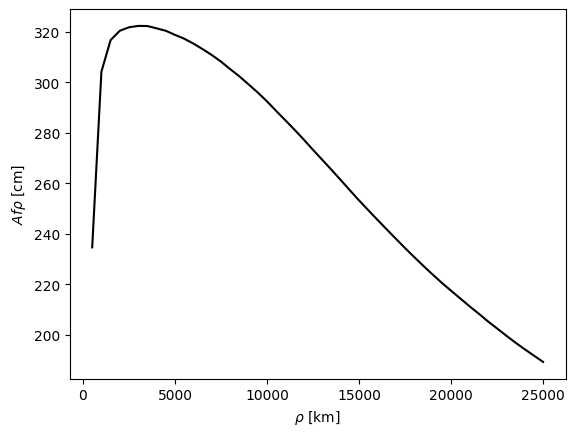

In [98]:
ctk.PlotAfrho(apRange, activity)